# Наивный Байес и спам
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][HW08] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

In [4]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import spacy
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize.regexp import RegexpTokenizer

In [5]:
import re
def read_dataset(filename):
    file = open(filename, encoding="utf-8")
    x = []
    y = []
    for line in file:
        cl, sms = re.split("^(ham|spam)[\t\s]+(.*)$", line)[1:3]
        x.append(sms)
        y.append(cl)
    return np.array(x, dtype=np.str), np.array(y, dtype=np.str)

In [6]:
def get_precision_recall_accuracy(y_pred, y_true):
    classes = np.unique(list(y_pred) + list(y_true))
    true_positive = dict((c, 0) for c in classes)
    true_negative = dict((c, 0) for c in classes)
    false_positive = dict((c, 0) for c in classes)
    false_negative = dict((c, 0) for c in classes)
    for c_pred, c_true in zip(y_pred, y_true):
        for c in classes:
            if c_true == c:
                if c_pred == c_true:
                    true_positive[c] = true_positive.get(c, 0) + 1
                else:
                    false_negative[c] = false_negative.get(c, 0) + 1
            else:
                if c_pred == c:
                    false_positive[c] = false_positive.get(c, 0) + 1
                else:
                    true_negative[c] = true_negative.get(c, 0) + 1
    precision = dict((c, true_positive[c] / max(1, true_positive[c] + false_positive[c])) for c in classes)
    recall = dict((c, true_positive[c] / max(1, true_positive[c] + false_negative[c])) for c in classes)
    accuracy = sum([true_positive[c] for c in classes]) / len(y_pred)
    return precision, recall, accuracy

def plot_precision_recall(X_train, y_train, X_test, y_test, bow_method, voc_sizes=range(4, 200, 5)):
    classes = np.unique(list(y_train) + list(y_test))
    precisions = dict([(c, []) for c in classes])
    recalls = dict([(c, []) for c in classes])
    accuracies = []
    for v in voc_sizes:
        bow = bow_method(X_train, voc_limit=v)
        X_train_transformed = bow.transform(X_train)
        X_test_transformed = bow.transform(X_test)
        classifier = NaiveBayes(0.001)
        classifier.fit(X_train_transformed, y_train)
        y_pred = classifier.predict(X_test_transformed)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in classes:
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("Vocabulary size")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(list(ys.values()))-0.01, np.max(list(ys.values()))+0.01)
        for c in ys.keys():
            plt.plot(x, ys[c], label="Class " + str(c))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(voc_sizes, recalls, "Recall")
    plot(voc_sizes, precisions, "Precision")
    plot(voc_sizes, {"":accuracies}, "Accuracy", legend=False)

In [7]:
X, y = read_dataset("spam")

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9)

### Задание 1 (3 балла)
Реализуйте классификацию методом Байеса в предположении независимости компонент `x`. При реализации следует считать, что значения каждой компоненты дискретны, а `p(x|y)` имеет мультиномиальное распределение.

#### Методы
`fit(X, y)` - оценивает параметры распределения `p(x|y)` для каждого `y`. 

`log_proba(X)` - для каждого элемента набора `X` считает логарифм вероятности отнести его к каждому классу. По теореме Байеса: `p(y|x) = p(y)p(x|y)/p(x)`. Соответственно, после логарифмирования: `log p(y|x) = log p(y) + log p(x|y) - log p(x)`. Поскольку `log p(x)` является независящей от класса `y` константой, это слагаемое никак не влияет на решение задачи максимизации. Поэтому его можно просто убрать для простоты.

In [13]:
class NaiveBayes:
    def __init__(self, alpha):
        self.alpha = alpha # Параметр аддитивной регуляризации
    
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.class_count = np.array([np.sum(y == c) for c in self.classes])
        self.total_count = len(y)
        self.feature_count = [
                [
                    dict() 
                    for _ in range(X.shape[1])
                ] 
                for label in range(len(self.classes))
            ] # cnt[y][x_i]
        for i, label in enumerate(self.classes):
            for x in X[np.arange(len(y))[y == label]]:
                for j, feature in enumerate(x):
                    if not feature in self.feature_count[i][j]:
                        self.feature_count[i][j][feature] = 0
                    self.feature_count[i][j][feature] += 1

    def predict(self, X):
        return [self.classes[i] for i in np.argmax(self.log_proba(X), axis=1)]
    
    def log_proba(self, X):
        proba = np.zeros((len(X), len(self.classes)))
        for i, x in enumerate(X):
            for j, label in enumerate(self.classes):
                proba[i][j] = np.log(self.class_count[j]) - np.log(self.total_count)
                for k, feature in enumerate(x):
                    fc = self.feature_count[j][k][feature] if feature in self.feature_count[j][k] else 0
                    proba[i][j] += np.log(fc + self.alpha)
                    proba[i][j] -= np.log(self.class_count[j] + self.alpha * len(self.feature_count[j][k]))
        return proba

### Задание 2 (3 балла)
Теперь реализуем метод bag of words. Задача состоит в том, чтобы посчитать количество вхождений каждого слова в предложение.

#### Методы
`__init__(X, voc_limit)` - инициализирует BoW, составляя словарь, который будет использоваться для векторизации предложений. Размер словаря должен быть не больше `voc_limit`, в него должны входить самые часто встречающиеся в выборке слова.

`transform(X)` - векторизует сообщения из набора.

In [55]:
def get_words_list(msg):
    return re.split(r'\W+', msg.lower())

class BoW:
    def __init__(self, X, voc_limit=1000):
        total = dict()
        for i, msg in enumerate(X):
            for word in get_words_list(msg):
                if not word in total:
                    total[word] = 0
                total[word] += 1
        self.bag = sorted(list(total.items()), key=lambda x: x[1], reverse=True)
        self.bag = self.bag[:min(len(self.bag), voc_limit)]
        self.bag = list(map(lambda x: x[0], self.bag))
        
    def transform(self, X):
        v = np.zeros((len(X), len(self.bag)))
        for i, msg in enumerate(X):
            xbag = {}
            for word in get_words_list(msg):
                if not word in xbag:
                    xbag[word] = 0
                xbag[word] += 1
            for j, w in enumerate(self.bag):
                if w in xbag:
                    v[i][j] = xbag[w]
        return v

In [56]:
bow = BoW(X_train, voc_limit=500)
X_train_bow = bow.transform(X_train)
X_test_bow = bow.transform(X_test)

In [57]:
predictor = NaiveBayes(0.001)
predictor.fit(X_train_bow, y_train)
get_precision_recall_accuracy(predictor.predict(X_test_bow), y_test)

({'ham': 0.9838709677419355, 'spam': 0.9838709677419355},
 {'ham': 0.9979550102249489, 'spam': 0.8840579710144928},
 0.9838709677419355)

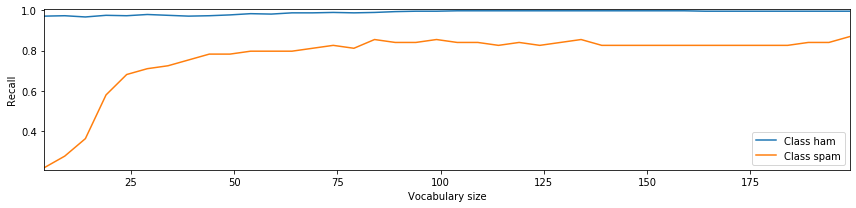

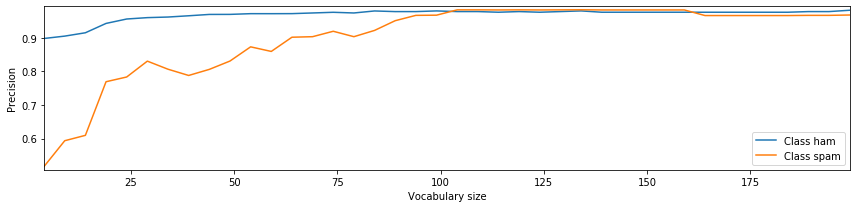

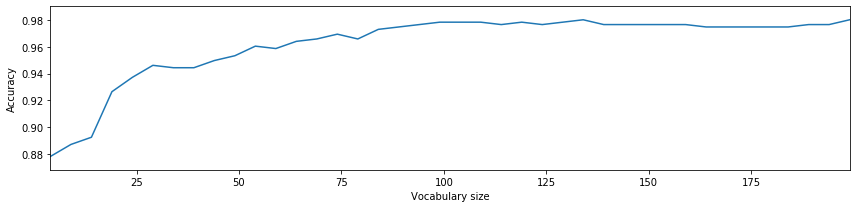

In [58]:
plot_precision_recall(X_train, y_train, X_test, y_test, BoW)

### Задание 3 (2 балла)
Теперь добавим в BoW стемминг. Для этого нам понадобится класс SnowballStemmer из пакета `nltk`

#### Методы
`__init__(X, voc_limit)` - инициализирует BoW, составляя словарь, который будет использоваться для векторизации предложений. Размер словаря должен быть не больше `voc_limit`, в него должны входить самые часто встречающиеся в выборке слова.

`transform(X)` - векторизует сообщения из набора.

In [64]:
def get_upgraded_words_list(msg, tokenizer, stemmer):
    return list(map(stemmer.stem, tokenizer.tokenize(msg.lower())))
#     tokens = tokenizer.tokenize(msg.lower())
#     return [stemmer.stem(w) for w in tokens]

class BowStem:
    def __init__(self, X, voc_limit=1000):
        self.tokenizer = RegexpTokenizer(r'[a-zA-Z]+')
        self.stemmer = SnowballStemmer('english')
        total = dict()
        total_unique = dict()
        for i, msg in enumerate(X):
            unique_words = set()
            for word in get_upgraded_words_list(msg, self.tokenizer, self.stemmer):
                if not word in total:
                    total[word] = 0
                total[word] += 1
                unique_words.add(word)
            for word in unique_words:
                if not word in total_unique:
                    total_unique[word] = 0
                total_unique[word] += 1
#         for x in total.keys():
#             total[x] /= total_unique[x]
        self.bag = sorted(list(total.items()), key=lambda x: x[1], reverse=True)
        self.bag = self.bag[:min(len(self.bag), voc_limit)]
        self.bag = list(map(lambda x: x[0], self.bag))
        
    def transform(self, X):
        v = np.zeros((len(X), len(self.bag)))
        for i, msg in enumerate(X):
            xbag = {}
            for word in get_upgraded_words_list(msg, self.tokenizer, self.stemmer):
                if not word in xbag:
                    xbag[word] = 0
                xbag[word] += 1
            for j, w in enumerate(self.bag):
                if w in xbag:
                    v[i][j] = xbag[w]
        return v

In [65]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/maximumshot/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [66]:
bows = BowStem(X_train, voc_limit=500)
X_train_bows = bows.transform(X_train)
X_test_bows = bows.transform(X_test)

In [67]:
predictor = NaiveBayes(0.001)
predictor.fit(X_train_bows, y_train)
get_precision_recall_accuracy(predictor.predict(X_test_bows), y_test)

({'ham': 0.976, 'spam': 0.9827586206896551},
 {'ham': 0.9979550102249489, 'spam': 0.8260869565217391},
 0.9767025089605734)

In [ ]:
plot_precision_recall(X_train, y_train, X_test, y_test, BowStem)